In [1]:
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')


# Train-Obtencion area

In [2]:
train = pd.read_csv(r'C:\Users\JORGE\Downloads\uniandes-bdml-202320-ps2\train.csv')

In [3]:
len(train)

38644

In [4]:
area_nan = train[train['surface_total'].isnull()]
area_sin_nan = train[train['surface_total'].notnull()]

In [5]:
area_nan['description'] = area_nan['description'].astype(str)
valores_final=[]
for i in area_nan['description']:
    # se usa de referencia las palabras: mts,metros,m,m2 y mt para poder encontrar el valor numerico
    r1 = re.findall(r"[0-9][0-9][0-9] +mts|[0-9][0-9][0-9]*mts|[0-9][0-9][0-9]* metros|[0-9][0-9][0-9]*metros|[0-9][0-9][0-9]* m|[0-9][0-9][0-9]*m|[0-9][0-9][0-9]* m2|[0-9][0-9][0-9]*m2|[0-9][0-9][0-9]* mt|[0-9][0-9][0-9]*mt", i)
    # se unen loas valores 
    valores = [''.join(re.findall(r"[0-9]", i)) for i in r1]
    valores_final.append(valores)
    # se cambian las listas vacias por nan
for i in range(len(valores_final)):
    if valores_final[i] ==[]:
        valores_final[i] = np.nan  
    else:
        pass
    # se agrega  ala base de datos
area_nan['surface_total'] = valores_final
        

In [6]:
lista = []
for i in area_nan['surface_total']:
    if type(i) == list:
        i = [int(j) for j in i]
        valor = max(i)
        lista.append(valor)
    elif type(i) == float:
        i = np.nan
        lista.append(i)


len(lista)+len(area_sin_nan)
area_nan['surface_total'] = lista

In [7]:
train = pd.concat([area_nan, area_sin_nan])

In [8]:
train.to_csv(r'C:\Users\JORGE\Documents\taller 2 bdml\train.csv')

# Data Augmentation usando Geopanpas(train)
En esta parte con datos gubernamentales y usando geopandas una herramienta parecida a las herramientas GIS, se van a agregar datos a la base

In [9]:
import matplotlib.pyplot as plt
import geopandas as gpd

# Agregar Manzanas

In [10]:
manzanas_gdf = gpd.read_file(r'C:\Users\JORGE\Downloads\estrato-socioeconomico-bogota-2019/estrato-socioeconomico-bogota-2019.shp')

<Figure size 30000x20000 with 0 Axes>

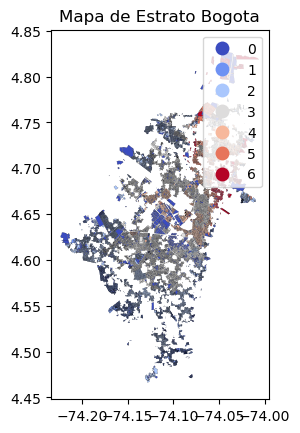

In [11]:
plt.figure(figsize=(300,200))
manzanas_gdf.plot(column='estrato', cmap='coolwarm', legend=True, edgecolor='black', linewidth=0.1)
plt.title('Mapa de Estrato Bogota')
plt.show()

In [12]:
from shapely.geometry import Point
# se convierte el csv a un geo pandas


geometry = [Point(lon, lat) for lon, lat in zip(train['lon'], train['lat'])]

# Crear un GeoDataFrame con el DataFrame de pandas y los objetos de geometría
gdf = gpd.GeoDataFrame(train, geometry=geometry)

# Guardar el GeoDataFrame como un archivo Shapefile o en otro formato si lo deseas
gdf.to_file(r'C:\Users\JORGE\Documents\taller 2 bdml\train_shapefile.shp')

In [13]:
casas_con_barrios = gpd.sjoin(gdf, manzanas_gdf, how='left', op='within')

# agregar barrios

In [14]:
drop = ['rooms','operation_type','title','description','surface_covered','index_right', 'codigo_manz', 'codigo_zona', 'codigo_crit',
       'normativa', 'acto_admini', 'numero_acto', 'fecha_acto_', 'escala_capt',
       'fecha_captu', 'responsable', 'objectid', 'shape_area', 'shape_len']
casas_con_barrios = casas_con_barrios.drop(drop, axis=1)

In [15]:
barrios = gpd.read_file(r'C:\Users\JORGE\Downloads\barrios\barrios_prueba.shp')
barrios = barrios.drop('localidad', axis=1)

In [16]:
train = gpd.sjoin(casas_con_barrios, barrios, how='left', op='within')

# ultima combinacionpara obtencion de baños y otras medidas hechas por compañeros

In [17]:
drop = ['bathrooms','city','lat', 'lon','index_right', 'objectid', 'cod_loc', 'cod_polbar', 'shape_area', 'shape_len']
train = train.drop(drop, axis=1)

In [18]:
train.to_csv(r'C:\Users\JORGE\Documents\taller 2 bdml\trainf.csv')

In [19]:
trainf = pd.read_csv(r'C:\Users\JORGE\Documents\taller 2 bdml\trainf.csv')

In [20]:
# cambiar aca la base sin dropear
basem = pd.read_csv(r'C:\Users\JORGE\Documents\taller 2 bdml\train-finaaal.csv', index_col=False)

In [21]:
basem = basem[['property_id','numeros_baños', 'v_ref','distancia_u_top', 'distancia_bar',
       'distancia_disco', 'distancia_w']]

In [22]:
trainf = trainf.merge(basem, left_on='property_id', right_on='property_id')

# rellenar nas

In [23]:
dic = {}
for i in trainf.columns:
    a = trainf[str(i)].isnull().value_counts()
    dic[str(i)] = len(trainf)-a[0]
dic

{'Unnamed: 0': 0,
 'property_id': 0,
 'price': 0,
 'month': 0,
 'year': 0,
 'surface_total': 17751,
 'bedrooms': 0,
 'property_type': 0,
 'geometry': 0,
 'estrato': 17214,
 'estado': 256,
 'barriocomu': 255,
 'numeros_baños': 0,
 'v_ref': 938,
 'distancia_u_top': 0,
 'distancia_bar': 0,
 'distancia_disco': 0,
 'distancia_w': 0}

In [24]:
# se dropean solo los nas de barrio
trainf.dropna(subset=['barriocomu'], inplace=True)

In [25]:
means = trainf.groupby(['barriocomu'])['surface_total'].mean()
trainf = trainf.set_index(['barriocomu'])
trainf['surface_total'] = trainf['surface_total'].fillna(means)
trainf = trainf.reset_index()


In [26]:
means = trainf.groupby(['barriocomu'])['estrato'].mean()
trainf = trainf.set_index(['barriocomu'])
trainf['estrato'] = trainf['estrato'].fillna(means)
trainf = trainf.reset_index()


In [27]:
means = trainf.groupby(['barriocomu'])['v_ref'].mean()
trainf = trainf.set_index(['barriocomu'])
trainf['v_ref'] = trainf['v_ref'].fillna(means)
trainf = trainf.reset_index()

In [28]:
# se dropean las que sobren
trainf = trainf.dropna(how='any',  axis=0)

# Base final train
en lugar de dropear los na se van a remplazar por la media de su barrio

In [29]:
trainf = trainf[['price', 'month', 'year', 'surface_total','property_type', 'estrato',
        'barriocomu', 'numeros_baños',  'v_ref',
        'distancia_bar', 'distancia_disco', 'distancia_w']]


In [30]:
trainf=trainf.drop_duplicates()
trainf = trainf.dropna(how='any',axis=0)

In [31]:
trainf.to_csv(r'C:\Users\JORGE\Documents\taller 2 bdml\traincompleto.csv')

# Para test

In [32]:
test = pd.read_csv(r'C:\Users\JORGE\Downloads\uniandes-bdml-202320-ps2\test.csv')

In [33]:
property_id = test['property_id']

In [34]:
area_nan = test[test['surface_total'].isnull()]
area_sin_nan = test[test['surface_total'].notnull()]

In [35]:
area_nan['description'] = area_nan['description'].astype(str)
valores_final=[]
for i in area_nan['description']:
    # se usa de referencia las palabras: mts,metros,m,m2 y mt para poder encontrar el valor numerico
    r1 = re.findall(r"[0-9][0-9][0-9] +mts|[0-9][0-9][0-9]*mts|[0-9][0-9][0-9]* metros|[0-9][0-9][0-9]*metros|[0-9][0-9][0-9]* m|[0-9][0-9][0-9]*m|[0-9][0-9][0-9]* m2|[0-9][0-9][0-9]*m2|[0-9][0-9][0-9]* mt|[0-9][0-9][0-9]*mt", i)
    # se unen loas valores 
    valores = [''.join(re.findall(r"[0-9]", i)) for i in r1]
    valores_final.append(valores)
    # se cambian las listas vacias por nan
for i in range(len(valores_final)):
    if valores_final[i] ==[]:
        valores_final[i] = np.nan  
    else:
        pass
    # se agrega  ala base de datos
area_nan['surface_total'] = valores_final

In [36]:
lista = []
for i in area_nan['surface_total']:
    if type(i) == list:
        i = [int(j) for j in i]
        valor = max(i)
        lista.append(valor)
    elif type(i) == float:
        i = np.nan
        lista.append(i)


len(lista)+len(area_sin_nan)
area_nan['surface_total'] = lista

In [37]:
test = pd.concat([area_nan, area_sin_nan])

In [38]:
test.to_csv(r'C:\Users\JORGE\Documents\taller 2 bdml\test.csv')

# Data Augmentation usando Geopanpas(test)

In [39]:
geometry = [Point(lon, lat) for lon, lat in zip(test['lon'], test['lat'])]

# Crear un GeoDataFrame con el DataFrame de pandas y los objetos de geometría
gdf = gpd.GeoDataFrame(test, geometry=geometry)

# Guardar el GeoDataFrame como un archivo Shapefile o en otro formato si lo deseas
gdf.to_file(r'C:\Users\JORGE\Documents\taller 2 bdml\train_shapefile.shp')

## agregar manzanas

In [40]:
casas_con_barrios = gpd.sjoin(gdf, manzanas_gdf, how='left', op='within')

In [41]:
drop = ['rooms','price','operation_type','title','description','surface_covered','index_right', 'codigo_manz', 'codigo_zona', 'codigo_crit',
       'normativa', 'acto_admini', 'numero_acto', 'fecha_acto_', 'escala_capt',
       'fecha_captu', 'responsable', 'objectid', 'shape_area', 'shape_len']
casas_con_barrios = casas_con_barrios.drop(drop, axis=1)

## Agregar barrios

In [42]:
test = gpd.sjoin(casas_con_barrios, barrios, how='left', op='within')

In [43]:
drop = ['bathrooms','estrato','city','lat', 'lon', 'geometry','index_right', 'objectid', 'cod_loc', 'cod_polbar', 'shape_area', 'shape_len']
test = test.drop(drop, axis=1)

In [44]:
test.to_csv(r'C:\Users\JORGE\Documents\taller 2 bdml\testf.csv')

In [45]:
testf = pd.read_csv(r'C:\Users\JORGE\Documents\taller 2 bdml\testf.csv')

In [46]:
basemt = pd.read_csv(r'C:\Users\JORGE\Documents\taller 2 bdml\test-finaaal.csv', index_col=False)

In [47]:
basemt = basemt[['estrato','property_id','numeros_baños', 'v_ref','distancia_u_top', 'distancia_bar',
       'distancia_disco', 'distancia_w']]

In [48]:
testf = testf.merge(basemt, left_on='property_id', right_on='property_id')

# NA test
los NA no se pueden borrar en test asi se que van a rellenar asi: para area, baños, habitaciones se va a usar la media de su barrio

In [49]:
# rellenar para surface_total, baños y estrato

In [50]:
# surface total
means = testf.groupby(['barriocomu'])['surface_total'].mean()
testf = testf.set_index(['barriocomu'])
testf['surface_total'] = testf['surface_total'].fillna(means)
testf = testf.reset_index()
testf['surface_total'] = testf['surface_total'].fillna(testf['surface_total'].mean())

In [51]:
# estrato
means = testf.groupby(['barriocomu'])['estrato'].mean()
testf = testf.set_index(['barriocomu'])
testf['estrato'] = testf['estrato'].fillna(means)
testf = testf.reset_index()
testf['estrato'] = testf['estrato'].fillna(testf['estrato'].mean())

In [52]:
# vref 

means = testf.groupby(['barriocomu'])['v_ref'].mean()
testf = testf.set_index(['barriocomu'])
testf['v_ref'] = testf['v_ref'].fillna(means)
testf = testf.reset_index()
testf['v_ref'] = testf['v_ref'].fillna(testf['v_ref'].mean())

In [53]:
dic = {}
for i in testf.columns:
    a = testf[str(i)].isnull().value_counts()
    dic[str(i)] = len(testf)-a[0]
dic

{'barriocomu': 0,
 'Unnamed: 0': 0,
 'property_id': 0,
 'month': 0,
 'year': 0,
 'surface_total': 0,
 'bedrooms': 0,
 'property_type': 0,
 'estado': 0,
 'estrato': 0,
 'numeros_baños': 0,
 'v_ref': 0,
 'distancia_u_top': 0,
 'distancia_bar': 0,
 'distancia_disco': 0,
 'distancia_w': 0}

In [54]:
testf.to_csv(r'C:\Users\JORGE\Documents\taller 2 bdml\testcompleto.csv')

# Base final test

In [55]:
# en test no hay price lo que significa que test es el mismo X
testf = testf[[ 'month', 'year', 'surface_total','property_type', 'estrato',
        'barriocomu', 'numeros_baños',  'v_ref',
        'distancia_bar', 'distancia_disco', 'distancia_w']]

In [56]:
trainf.columns

Index(['price', 'month', 'year', 'surface_total', 'property_type', 'estrato',
       'barriocomu', 'numeros_baños', 'v_ref', 'distancia_bar',
       'distancia_disco', 'distancia_w'],
      dtype='object')

In [57]:
testf.columns

Index(['month', 'year', 'surface_total', 'property_type', 'estrato',
       'barriocomu', 'numeros_baños', 'v_ref', 'distancia_bar',
       'distancia_disco', 'distancia_w'],
      dtype='object')

# Modelos
-modelos
-normal
-inflacion
-cross validation
-solo con mis variables

## obtencion de dummies
para obtener las dummies se van a concatenar las bases y luego volver a separarlas para que quede con dummies de todos los barrios

In [59]:
trainf['indicador'] = ['trainf']*len(trainf)
testf['indicador'] = ['testf']*len(testf)
# se concatenan
total = pd.concat([trainf,testf], axis=0)
# se obtienen las dummies para que ambas tengan la misma cantidad de dummies de barrios
total = pd.get_dummies(total)
# se vuelven a dividir
trainf = total[total['indicador_trainf']==1]
testf = total[total['indicador_testf']==1]
# se droopen los indicadores 
trainf = trainf.drop(['indicador_testf','indicador_trainf'], axis=1)
testf = testf.drop(['indicador_testf','indicador_trainf','price'], axis=1)

                     
    
        
    
    
        

## primer modelo con todas mis varibles y las de mi grupo

In [60]:
y_train_1 = trainf['price']
X_train_1 = trainf.drop(['price'], axis=1)
X_test_1 = testf 

In [61]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
def random_forest(X_train, y_train, X_test, max_depth, path_salida):
    predicciones_frame = pd.DataFrame()
    rf = RandomForestRegressor(max_depth=max_depth, random_state=0)
    rf.fit(X_train,y_train)
    # estas predicciones se guardan para la evaluacion
    predicciones = rf.predict(X_test)
    # se va a predecir X_train tambien para saber el mae
    predicciones_frame['property_id'] = property_id
    predicciones_frame['price'] = predicciones
    predicciones_frame.to_csv(path_salida, index=False)
    return predicciones_frame
                  
    

In [63]:
random_forest(X_train_1, y_train_1, X_test_1, 5, r'C:\Users\JORGE\Documents\taller 2 bdml\predicciones2.csv')

,property_id,price
0,d56159653f5d2abc5ed5acd7,8.192992e+08
1,45550aa81c0151f1fd9fd8fe,6.063534e+08
2,735deef3382aa15930482f3e,6.063534e+08
3,0dd49fa8bb7be52b851c6dc9,9.880223e+08
4,7d3220a91e78f8bc2924d1cd,8.598759e+08
...,...,...
10281,224f6e839dcbd91491f3f1ac,4.691191e+08
10282,8ee7d2e0692e49bf9d308b4b,8.103854e+08
10283,a3ff6a1fe37a1bb736b1100d,6.181155e+08
10284,97d49e61c1ef55451e52c8e7,8.028805e+08


In [ ]:
trainf = pd.read_csv(r'C:\Users\JORGE\Documents\taller 2 bdml\train_corta.csv')

In [ ]:
trainf.columns

In [ ]:
testf.columns

In [ ]:
y_train_1 = trainf['price']
X_train_1 = trainf.drop(['price'], axis=1)
X_test_1 = testf 